## **Supervised learning methods: Decision trees, Random Forests, Gradient Boosting, Caliberation**

## **The** **Dataset**

### Description
This dataset contains details of individual relating to their health. The target is stored in **strokes** column which is binary variable indicating either 0 or 1. The goal is a binary classification task to predict wether the person will get a stroke depending on other health factors

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
import time
import xgboost as xgb
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay

## **Decision Trees**

**Load the dataset**

In [ ]:
df = pd.read_csv('./Data/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**Check missing values**

In [ ]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<Axes: >

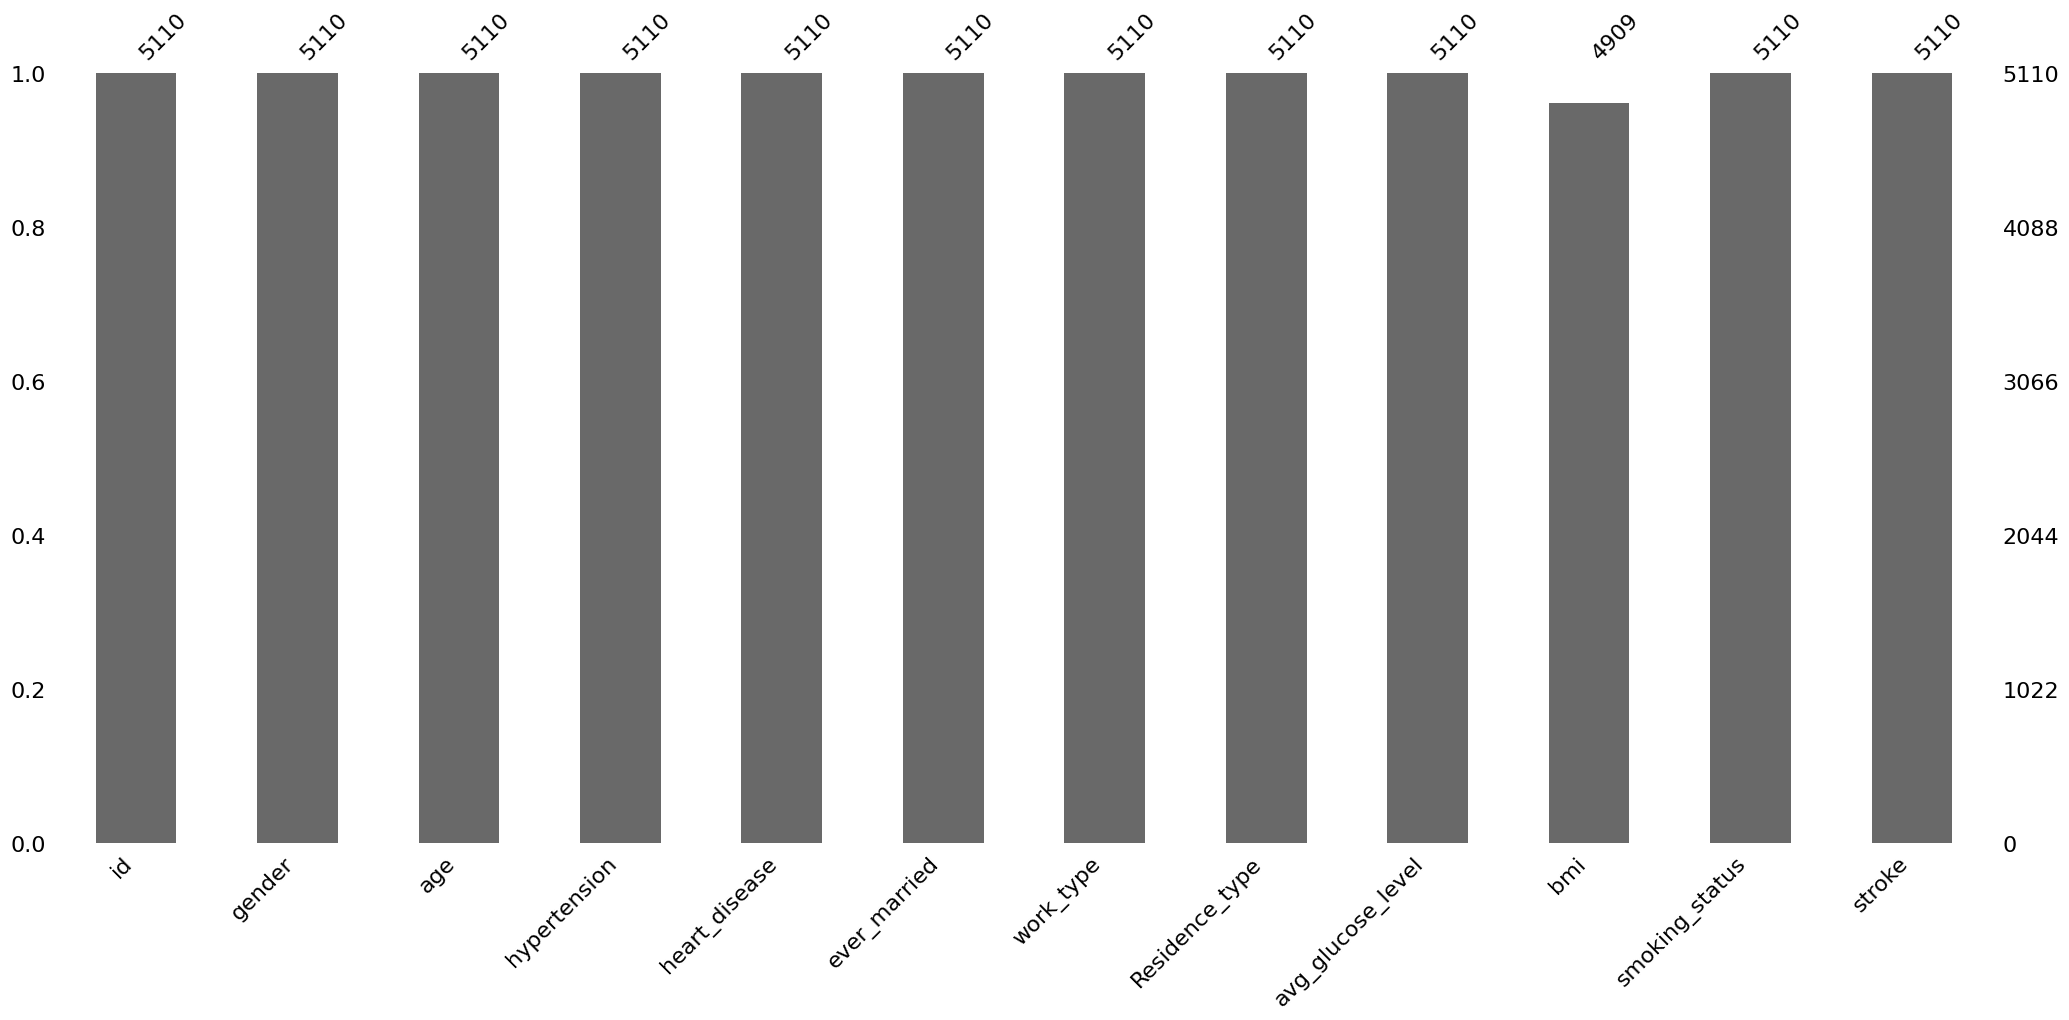

In [ ]:
# Plot missing values as a %
msno.bar(df)
# We see that only `bmi` variable has missing values (~3% missing)

We have three options:
- Drop the column with missing values: We don't know feature importance at this stage, so this is unwise.
- Impute: We could impute using median/mean or LR.
- Drop the missing values: As missing values comprise of <5% of the data, we can simply drop those rows. However, as we'll later see, the data is highly imbalanced, so this step may contribute to further reducing the count of minority class in the dataset.

Based on the options above, I will go with option 2.

Note: I tested two approaches - dropping all missing values and imputation. I did not see any significant difference in model performance.

In [ ]:
# Impute missing values with median
df['bmi'].fillna(df['bmi'].median(), inplace=True)

**Check for the number of rows after handling null values.**

In [ ]:
df.count()

id                   5110
gender               5110
age                  5110
hypertension         5110
heart_disease        5110
ever_married         5110
work_type            5110
Residence_type       5110
avg_glucose_level    5110
bmi                  5110
smoking_status       5110
stroke               5110
dtype: int64

**Check distribution of target variable**

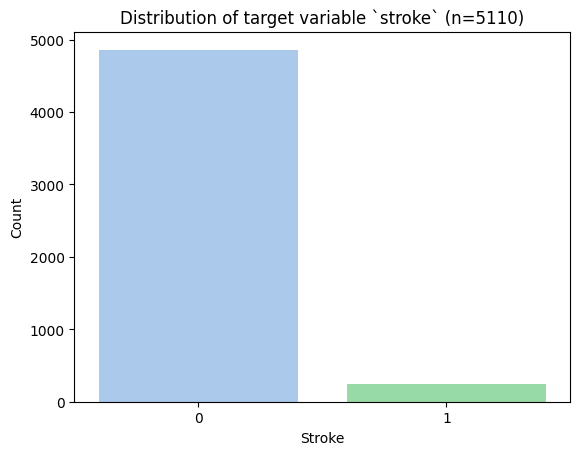

In [ ]:
# Set palette
sns.set_palette("pastel6")

sns.countplot(data=df,x="stroke")
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Distribution of target variable `stroke` (n=5110)')
plt.show()

In [ ]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

**Comments**: The target variable `stroke` exhibits a high class imbalance, with '0' (indicating no stroke) occurring at a frequency of 95%.

In [ ]:
# Extract categorical variables for plotting
df_cat = df.drop(['id','age','avg_glucose_level','bmi'], axis=1)

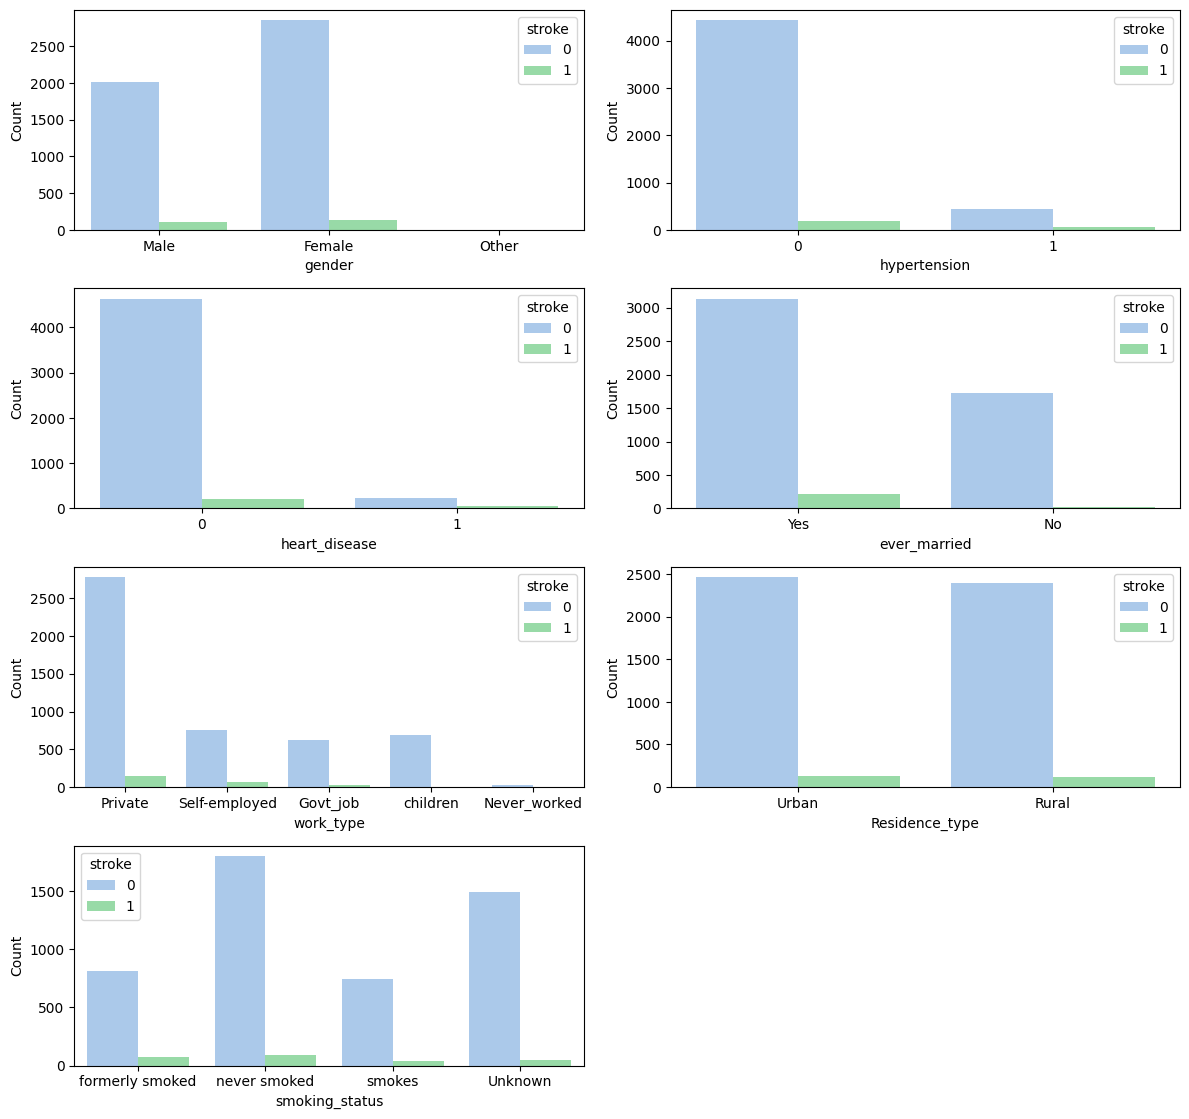

In [ ]:
# Plot distribution subplots
plt.figure(figsize=(12, 22))

for i, col in enumerate(df_cat):
  if col != 'stroke':  # Exclude 'stroke' from subplots
        plt.subplot(8, 2, i+1)
        sns.countplot(data=df_cat, x=col, hue="stroke")
        plt.xlabel(col)
        plt.ylabel('Count')

plt.tight_layout()
plt.show()
plt.clf()

plt.close('all')


In [ ]:
# We see that target variable is imbalanced for all categorical variables.

**Preprocess the data**

In [ ]:
df_X = df.drop(columns=['stroke','id'])
df_Y = df['stroke'].astype(int)

In [ ]:
# We do not need to apply scaling because any monotonic transformation won't affect the splits of the tree.
# However, scikit-learn would not be able to process categorical data w/o numerical encoding. We will apply LabelEncoder to categroical variables (exc ept the ones which are alreayd numerically ended, such as heart_disease).b

In [ ]:
df_X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


In [ ]:
columns_to_encode = ['smoking_status', 'ever_married', 'gender', 'work_type', 'Residence_type']

df_X = pd.get_dummies(df_X, columns=columns_to_encode) #OHE

#encoder = LabelEncoder()
# Iterate over columns and encode each one
#for col in columns_to_encode:
   # df_X[col] = encoder.fit_transform(df_X[col])

**Comments**: For categorical variables, the following types of encoding were tested:
- Label encoding
- OHE

There was slight improvement in performance with OHE. We opted against using ordinal encoding for the variable `smoking_status`, as it has a high # of observations under the categorical 'Unknown'.

For numerical variables, we don't necessarily need to apply scaling as monotonic transformations do not affect the structure of the tree.

**Split the data into development and test datasets.**

In [ ]:
# Split data intro train (or development) set and test set
df_X_train, df_X_test, df_Y_train, df_Y_test = train_test_split(df_X, df_Y, test_size=0.2,stratify=df_Y, random_state=3427) # use stratified sampling to account for imbalance in Y

# Verify the shape of the resulting sets
print("X development dataset shape:", df_X_train.shape)
print("X test dataset shape:", df_X_test.shape)
print("y development dataset shape:", df_Y_train.shape)
print("y test dataset shape:", df_Y_test.shape)

X development dataset shape: (4088, 21)
X test dataset shape: (1022, 21)
y development dataset shape: (4088,)
y test dataset shape: (1022,)


**Fit a Decision Tree on the training data until all leaves are pure.**

In [ ]:
clf = DecisionTreeClassifier(criterion="entropy", random_state=3427)

In [ ]:
clf.fit(df_X_train,df_Y_train)

DecisionTreeClassifier(criterion='entropy', random_state=3427)

In [ ]:
# Performance on development set
print(clf.score(df_X_train, df_Y_train))
print(clf.score(df_X_test, df_Y_test))

1.0
0.9178082191780822


In [ ]:
# Predict Y
df_Y_pred = clf.predict(df_X_test)

In [ ]:
decisiontree_accuracy_score = metrics.accuracy_score(df_Y_test, df_Y_pred)
decisiontree_precision = metrics.precision_score(df_Y_test, df_Y_pred, pos_label=1)
decisiontree_recall = metrics.recall_score(df_Y_test, df_Y_pred, pos_label=1)
decisiontree_f1 = metrics.f1_score(df_Y_test, df_Y_pred, pos_label=1)


# Performance on test set
print(f"Accuracy score:",
      decisiontree_accuracy_score)
print(f"Recall score:",
      decisiontree_recall)
print(f"Precision score:",
      decisiontree_precision)
print(f"F-1 score:",
      decisiontree_f1)

Accuracy score: 0.9178082191780822
Recall score: 0.08
Precision score: 0.09523809523809523
F-1 score: 0.08695652173913043


**Comments**: We see that while accuracy score is 92%, precision and recall scores are very poor at ~9%. This means that the decision tree model we specified fails to classify positive class (`stroke` = 1) correctly.

**Visualized the trained tree until the max_depth 8**

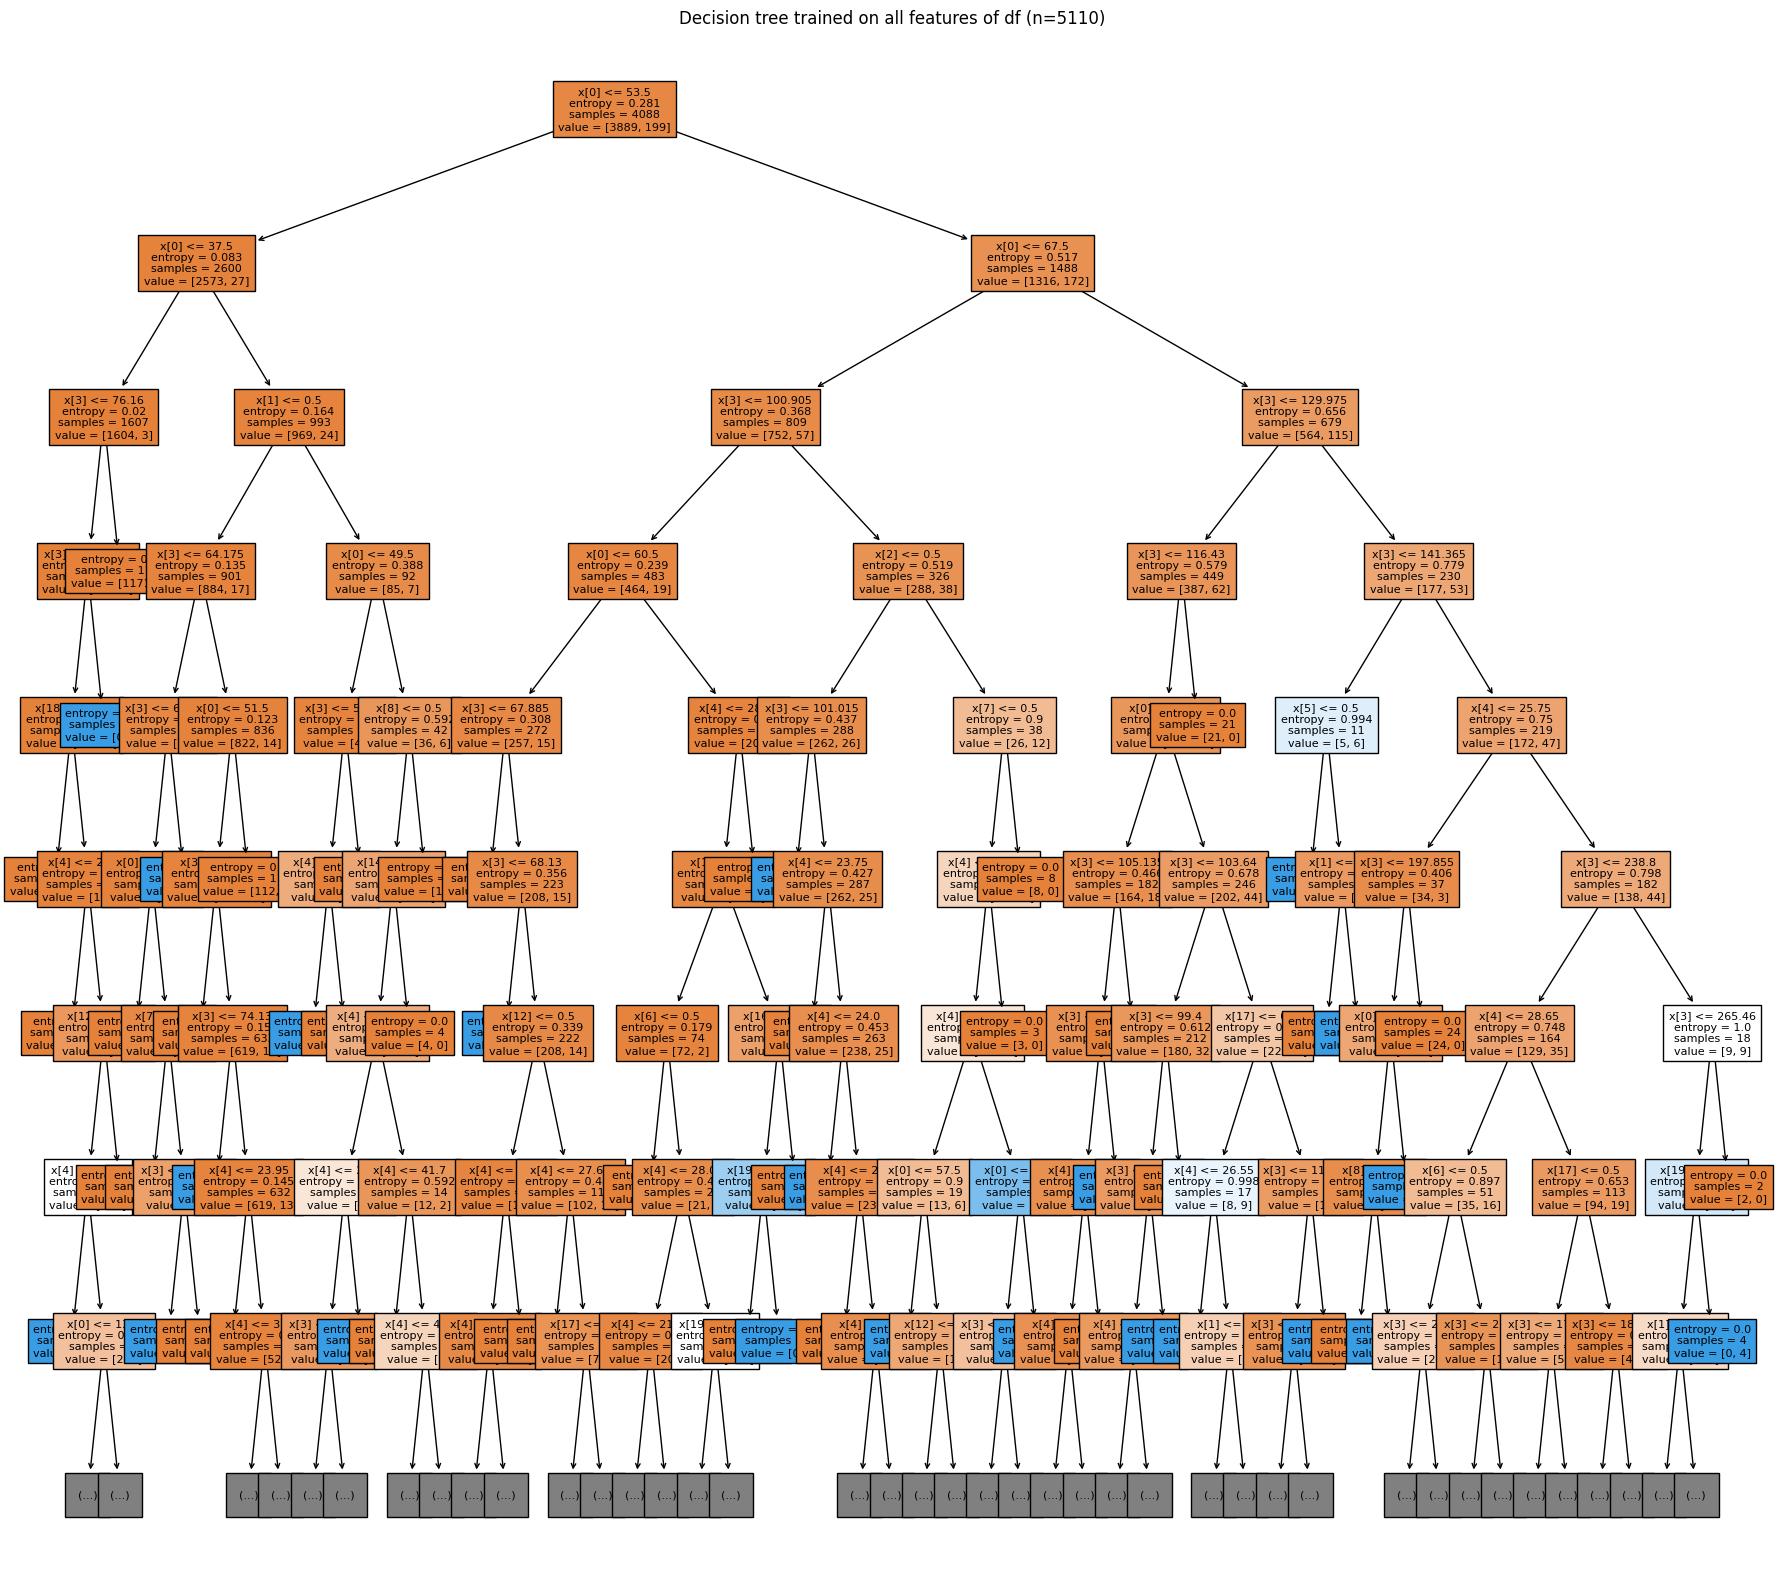

In [ ]:
plt.figure(figsize=(22,20)) #adjust the plot size to see details of each node.
plot_tree(clf, filled=True, max_depth=8,fontsize=8)
plt.title("Decision tree trained on all features of df (n=5110)")
plt.show()

**Prune the tree and evaluate the performance.**

In [ ]:
## Approach 1: Using maximum depth
model1 = RandomizedSearchCV(estimator = DecisionTreeClassifier(criterion="entropy", random_state=3427),
                   param_distributions = [{"max_depth":np.arange(1,10)}],
                   cv = 5, n_iter = 100,
                            return_train_score=True, random_state=3427)
model1.fit(df_X_train,df_Y_train)
df_Y_pred = model1.predict(df_X_test)
# Print performance
random_search_results = model1.cv_results_


print(f"Best score:", model1.best_score_)
print(f"Best alpha value:", model1.best_params_)
print(f"Test Score", model1.score(df_X_test, df_Y_test))
print(f"F-1 score:", metrics.f1_score(df_Y_test, df_Y_pred)) # default pos_label is  1

Best score: 0.9513211014116288
Best alpha value: {'max_depth': 1}
Test Score 0.9510763209393346
F-1 score: 0.0


In [ ]:
## Approach 2: Using maximum leaf nodes
model2 = RandomizedSearchCV(estimator = DecisionTreeClassifier(criterion="entropy", random_state=3427),
                   param_distributions = [{"max_leaf_nodes":np.arange(1,10)}],
                   cv = 5, n_iter = 100,
                            return_train_score=True, random_state=3427)
# Fit the model
model2.fit(df_X_train,df_Y_train)
df_Y_pred = model2.predict(df_X_test)

# Print performance
random_search_results = model2.cv_results_
print(f"Best score:", model2.best_score_)
print(f"Best alpha value:", model2.best_params_)
print(f"Test Score", model2.score(df_X_test, df_Y_test))
print(f"F-1 score:", metrics.f1_score(df_Y_test, df_Y_pred))

Best score: 0.9513211014116288
Best alpha value: {'max_leaf_nodes': 2}
Test Score 0.9510763209393346
F-1 score: 0.0


In [ ]:
## Approach 3: Using minimum impurity decrease
model3 = RandomizedSearchCV(estimator = DecisionTreeClassifier(criterion="entropy", random_state=3427),
                   param_distributions = [{"min_impurity_decrease":np.random.uniform(0, 0.05, 20)}],
                   cv = 5, n_iter = 100,
                            return_train_score=True, random_state=3427)
# Fit the model
model3.fit(df_X_train,df_Y_train)

df_Y_pred = model3.predict(df_X_test)

# Print performance
random_search_results = model3.cv_results_
print(f"Best score:", model3.best_score_)
print(f"Best alpha value:", model3.best_params_)
print(f"Test Score", model3.score(df_X_test, df_Y_test))
print(f"F-1 score:", metrics.f1_score(df_Y_test, df_Y_pred))

Best score: 0.9513211014116288
Best alpha value: {'min_impurity_decrease': 0.03341832171807939}
Test Score 0.9510763209393346
F-1 score: 0.0


In [ ]:
feat_dict= {}
for col, val in sorted(zip(df_X_train.columns, clf.feature_importances_),key=lambda x:x[1],reverse=True): # Used previous classifier ('clf') as it's precision score (0.09) was higher than the tuned models.
  feat_dict[col]=val
# Source: This piece of code is inspired from 'Feature Importance and Visualization of Tree Models' article on Medium; link: https://medium.com/chinmaygaikwad/feature-importance-and-visualization-of-tree-models-d491e8198b0a.

In [ ]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
feat_df

,Feature,Importance
0,avg_glucose_level,0.296125
1,age,0.287348
2,bmi,0.224856
3,smoking_status_never smoked,0.021369
4,hypertension,0.020907
5,smoking_status_formerly smoked,0.018525
6,work_type_Self-employed,0.018106
7,Residence_type_Rural,0.017699
8,work_type_Private,0.017104
9,heart_disease,0.016550


**Comments**
We used early stopping and feature importance methods to prune the decision tree. Details below:
- Early stopping using maximum depth (1 to 10, iterated 100 times); resultant best score = 95.13%, precision score = 0.0
- Early stopping using maximum leaf nodes (1 to 10, iterated 100 times); resultant best score was also 95.13, precision score = 0.0
- Early stopping using minimum impurity decrease (uniform random var from 0 to 0.05, 20 values); resultant best score = 95.13%, precision score = 0.0
- Feature importance: This suggests that top three feaures (`age`, `avg_glucose_level`, `bmi`) have the highest importance.

We did not use cost complexity technique for pruning the tree, as it retains the most popular class in each node - which, in imbalanced dataset, would be non-positive class (`stress` = 0). We also didn't use early stopping by specifying min. samples split as this would find optimal sample split based on *random* splitting, which doesn't make sense in case of imbalanced dataset.

**Conclusion**: As the dataset is imbalanced, we use alternate metrics such as precision score to evaluate model performance. The only promising pruning method based on this metric is feature selection based on importance.

**Feature importance**

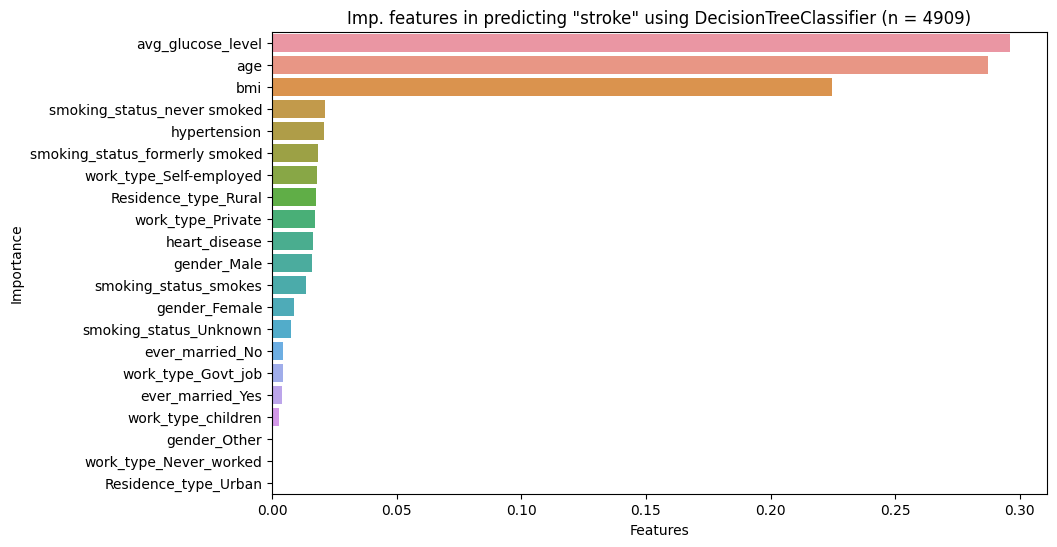

In [ ]:
plt.figure(figsize=(10, 6))
plot2 = sns.barplot(x=feat_df.Importance, y=feat_df.Feature)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Imp. features in predicting "stroke" using DecisionTreeClassifier (n = 4909)')

plt.show()

**Comments**

Three most imp. features for this trained tree are `age`, `avg_glucose_level`, `bmi`. Based on the plot above, we can see that they have the highest importance in DecisionTreeClassifier model.

## **Random Forests**

**Train a Random Forest model on the development dataset using RandomForestClassifier class in sklearn. Use the default parameters.**

In [ ]:
model2 = RandomForestClassifier(random_state=3427, oob_score=True)
model2.fit(df_X_train, df_Y_train)

df_Y_pred_RF = model2.predict(df_X_test)

In [ ]:
# Performance
rf_accuracy =metrics.accuracy_score(df_Y_test, df_Y_pred_RF)
rf_precision =metrics.precision_score(df_Y_test, df_Y_pred_RF, pos_label=1)  # default pos_label is  1
rf_recall =metrics.recall_score(df_Y_test, df_Y_pred_RF, pos_label=1)  # default pos_label is  1
rf_f1 =metrics.f1_score(df_Y_test, df_Y_pred_RF, pos_label=1)  # default pos_label is  1

print(f"Accuracy score:",rf_accuracy)
print(f"Recall score:",rf_recall)
print(f"Precision score:",rf_precision)
print(f"F-1 score:",rf_f1)

Accuracy score: 0.9510763209393346
Recall score: 0.0
Precision score: 0.0
F-1 score: 0.0


**Comments**
Random forest performed worse than simple DecisionTree. Possible reasons behind this is the fact that the dataset is highly imbalanced with positive class comprising of <5% of values. RF uses bootstrap sampling, where the default is random sampling. When dataset is imbalanced, random sampling (or non-stratified sampling) could lead to even skewed distribution in subset of data used for each tree.


**Choose parameters for hyperparameter tuning (limited to two)**

Given the imbalanced nature of the dataset, I would use 'balanced sub-sample' in class_weight to improve the performance of the RF model. With regards to hyperparameters, I would check
- n_estimators: One of the issues with imbalanced dataset is low sample count for minority class. Increasing the no. of trees and sub-samples could help with this.
- min_samples_split: I would also checked min. samples for each internal node, as lower number of samples (default is 2) could prevent the tree from capturing small variations in the data.

**Perform model selection using the chosen values for the hyperparameters**

In [ ]:
n_estimators_values = [100, 200, 300, 400, 500]
min_samples_split_values = [2, 5, 10, 20, 30]


param_grid = {
    'n_estimators': n_estimators_values,
    'min_samples_split': min_samples_split_values
}

In [ ]:
# We use 5 fold CV using Grid Search with both F-1 score and Accuracy score for evaluation (as F-1 score is more robust given imbalance in the dataset)

grid_search_f1 = GridSearchCV(estimator=model2, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1) # GridSearchCV using F-1 score
grid_search_accuracy = GridSearchCV(estimator=model2, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1) # GridSearchCV using accuracy score

# Fit the grid search to the data
grid_search_f1.fit(df_X_train, df_Y_train)
grid_search_accuracy.fit(df_X_train, df_Y_train)

# Best hyperparameters from the grid_search_f1
best_n_estimators_f1 = grid_search_f1.best_params_['n_estimators']
best_min_samples_split_f1 = grid_search_f1.best_params_['min_samples_split']

# Best hyperparametesr from the grid_search_accuracy
best_n_estimators_a = grid_search_accuracy.best_params_['n_estimators']
best_min_samples_split_a = grid_search_accuracy.best_params_['min_samples_split']

In [ ]:
# Train using the optimal hyperparameters using precision score to evaluate
optimal_rf_model_f1 = RandomForestClassifier(n_estimators=best_n_estimators_f1, min_samples_split=best_min_samples_split_f1, random_state=3427)
optimal_rf_model_f1.fit(df_X_train, df_Y_train)

# Train the model using the optimal hyperparameters using accuracy score to evaluate
optimal_rf_model_a = RandomForestClassifier(n_estimators=best_n_estimators_a, min_samples_split=best_min_samples_split_a, random_state=3427)
optimal_rf_model_a.fit(df_X_train, df_Y_train)

# Predictions on the test dataset
df_Y_pred_f1 = optimal_rf_model_f1.predict(df_X_test)
df_Y_pred_a = optimal_rf_model_a.predict(df_X_test)

# Calculate evaluation scores on the test dataset
test_f1_f1 = metrics.f1_score(df_Y_test, df_Y_pred_f1, pos_label=1)
test_f1_precision = metrics.precision_score(df_Y_test, df_Y_pred_f1, pos_label=1)
test_f1_recall = metrics.recall_score(df_Y_test, df_Y_pred_f1, pos_label=1)

test_accuracy_a = metrics.accuracy_score(df_Y_test, df_Y_pred_a)
test_accuracy_f1 = metrics.f1_score(df_Y_test, df_Y_pred_a)
test_a_precision = metrics.precision_score(df_Y_test, df_Y_pred_f1, pos_label=1)
test_a_recall = metrics.recall_score(df_Y_test, df_Y_pred_f1, pos_label=1)

# Report the optimal hyperparameters and test precision
print("Optimal Hyperparameters (using F-1 score):")
print("n_estimators (F-1 score):", best_n_estimators_f1)
print("min_samples_split (F-1 score):", best_min_samples_split_f1)
print("Estimated Performance on Test Dataset:")
print("F-1 score:", test_f1_f1)
print("Precision score:", test_f1_precision)
print("Recall score:", test_f1_recall)

print("\nOptimal Hyperparameters (using accuracy score):")
print("n_estimators (accuracy scoring):", best_n_estimators_a)
print("min_samples_split (accuracy scoring):", best_min_samples_split_a)
print("Estimated Performance on Test Dataset:")
print("Accuracy score:", test_accuracy_a)
print("F-1 score:", test_accuracy_f1)
print("Precision score:", test_a_precision)
print("Recall score:", test_a_recall)

Optimal Hyperparameters (using F-1 score):
n_estimators (F-1 score): 400
min_samples_split (F-1 score): 2
Estimated Performance on Test Dataset:
F-1 score: 0.0
Precision score: 0.0
Recall score: 0.0

Optimal Hyperparameters (using accuracy score):
n_estimators (accuracy scoring): 100
min_samples_split (accuracy scoring): 20
Estimated Performance on Test Dataset:
Accuracy score: 0.9510763209393346
F-1 score: 0.0
Precision score: 0.0
Recall score: 0.0


**Feature improtance**

In [ ]:
feat_dict= {}
for col, val in sorted(zip(df_X_train.columns, optimal_rf_model_f1.feature_importances_),key=lambda x:x[1],reverse=True): # Used optimal RF model.
  feat_dict[col]=val
# This piece of code is inspired from 'Feature Importance and Visualization of Tree Models' article on Medium; link: https://medium.com/chinmaygaikwad/feature-importance-and-visualization-of-tree-models-d491e8198b0a.

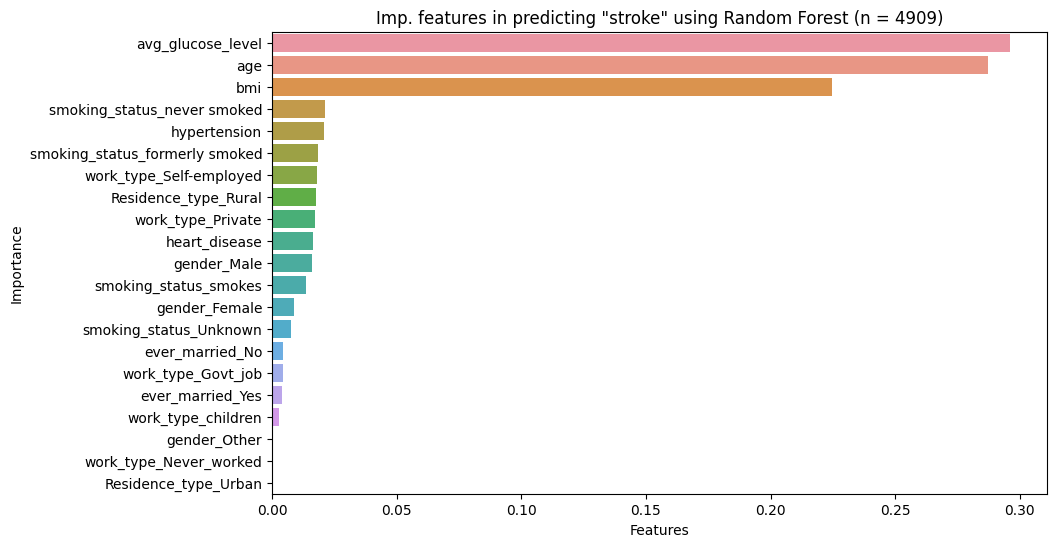

In [ ]:
plt.figure(figsize=(10, 6))
plot2 = sns.barplot(x=feat_df.Importance, y=feat_df.Feature)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Imp. features in predicting "stroke" using Random Forest (n = 4909)')

plt.show()

**Comments:** The top 3 most imp. features from RanDom Forest model is the same as those from Decision Tree model (`age`, `bmi`, `avg_glucose_level`).

In case theyw ere different, the features selected in Random Forest would make more sense as they are bootstrapped samples of features and data points over hundreds of decision trees, and more likely to approximate actual distribution than a single decision tree model.

##**Gradient Boosted Trees**

In [ ]:
# Define the parameter grid for tuning; we chose a default, mdeium and high value for each hyperparameter of interest
gb_param_grid = { # hyperparameters for  GradientBoostingClassifier
    'n_estimators': [100,200,300],
    'learning_rate': [0.01, 0.08, 0.2,0.3,0.5,0.8],
    'max_depth': [1,3,6,9]}

hist_gb_param_grid = { # hyperparameters for  HistGradientBoostingClassifier
    'max_iter': [50, 100, 150],
    'learning_rate': [0.01, 0.08, 0.2,0.3,0.5,0.8,1,1.3,1.5,1.6],
    'max_depth': [1,3,6,9]}

In [ ]:
# Initialize models
gb = GradientBoostingClassifier(random_state=3427)
hist_gb = HistGradientBoostingClassifier(random_state=3427)

In [ ]:
# Perform GridSearchCV for GradientBoostingClassifier
start_time = time.time() #start time record
gb_grid_search = GridSearchCV(gb, gb_param_grid, cv=5, scoring='f1', n_jobs=-1)
gb_grid_search.fit(df_X_train, df_Y_train)
gb_time_taken = time.time()-start_time # find total time

# Perform GridSearchCV for HistGradientBoostingClassifier
start_time = time.time()
hist_gb_grid_search = GridSearchCV(hist_gb, hist_gb_param_grid, cv=5, scoring='f1', n_jobs=-1)
hist_gb_grid_search.fit(df_X_train, df_Y_train)
hist_gb_time_taken = time.time()-start_time

In [ ]:
# Get the best models from grid search
best_gb_model = gb_grid_search.best_estimator_
best_hist_gb_model = hist_gb_grid_search.best_estimator_

# Get best hyperparams
best_learning_rate_gb = gb_grid_search.best_params_['learning_rate']
best_learning_rate_hist_gb = hist_gb_grid_search.best_params_['learning_rate']

# Evaluate best models on the test dataset
gb_test_f1_score = metrics.f1_score(df_Y_test, best_gb_model.predict(df_X_test))
hist_gb_test_f1_score = metrics.f1_score(df_Y_test, best_hist_gb_model.predict(df_X_test))

# Get results
print("GradientBoostingClassifier:")
print("Time taken for model selection: {:.2f} seconds".format(gb_time_taken))
print("F1-score on test dataset: {:.4f}".format(gb_test_f1_score))
print("Best hyperparameters (learning rate):",best_learning_rate_gb)

print("\nHistGradientBoostingClassifier:")
print("Time taken for model selection: {:.2f} seconds".format(hist_gb_time_taken))
print("F1-score on test dataset: {:.4f}".format(hist_gb_test_f1_score))
print("Best hyperparameters (learning rate):",best_learning_rate_hist_gb)

GradientBoostingClassifier:
Time taken for model selection: 588.57 seconds
F1-score on test dataset: 0.1316
Best hyperparameters (learning rate): 0.8

HistGradientBoostingClassifier:
Time taken for model selection: 112.83 seconds
F1-score on test dataset: 0.2727
Best hyperparameters (learning rate): 1


**Comments** :

HistGradientBooster model results in a has a much higher F-1 score, as compared to any methods tried so far (Gradient Boost, Random Forest, Decision Tree Classifier). It also takes lesser time as compared to Gradient Boost.

**Train an XGBoost model by tuning 3 hyperparameters using 10 fold cross-validation.**

In [ ]:
xgb_param_grid = { # hyperparameters for  XGBoost
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.08, 0.2,0.3,0.5,0.8,1],
    'max_depth': [1,3,6,9]}


xgboost = xgb.XGBClassifier(random_state=3427) # initialize model

# Perform grid search 10 cross-validation
start_time = time.time()
xgb_grid_search = GridSearchCV(xgboost, xgb_param_grid, cv=10, scoring='f1', n_jobs=-1)
xgb_grid_search.fit(df_X_train, df_Y_train)
xgb_gb_time_taken = time.time() - start_time # record time

best_xgb_model = xgb_grid_search.best_estimator_

xgb_test_f1_score = metrics.f1_score(df_Y_test, best_xgb_model.predict(df_X_test))

best_learning_rate_xgboost = xgb_grid_search.best_params_['learning_rate']


In [ ]:
# Just to cover all bases, calculate other metrics (precision, recall).
gb_test_precision = metrics.precision_score(df_Y_test, best_gb_model.predict(df_X_test))
gb_test_recall = metrics.recall_score(df_Y_test, best_gb_model.predict(df_X_test))

hist_gb_test_precision_score = metrics.precision_score(df_Y_test, best_hist_gb_model.predict(df_X_test))
hist_gb_test_recall_score = metrics.recall_score(df_Y_test, best_hist_gb_model.predict(df_X_test))

xgb_test_precision_score = metrics.precision_score(df_Y_test, best_xgb_model.predict(df_X_test))
xgb_test_recall_score = metrics.recall_score(df_Y_test, best_xgb_model.predict(df_X_test))

In [ ]:
# Compare results of all three models
print("XGBoost Classifier:")
print("F1 score on test dataset: {:.4f}".format(xgb_test_f1_score))
print("Precision score on test dataset: {:.4f}".format(xgb_test_precision_score))
print("Recall score on test dataset: {:.4f}".format(xgb_test_recall_score))
print("Best learning rate:", best_learning_rate_xgboost)
print("Time taken for model selection: {:.2f} seconds".format(xgb_gb_time_taken))

# Previous models
print("\nGradientBoostingClassifier from 3.1:")
print("F1 score on test dataset: {:.4f}".format(gb_test_f1_score))
print("Precision score on test dataset: {:.4f}".format(gb_test_precision))
print("Recall score on test dataset: {:.4f}".format(gb_test_recall))
print("Best learning rate:", best_learning_rate_gb)
print("Time taken for model selection: {:.2f} seconds".format(gb_time_taken))

print("\nHistGradientBoostingClassifier from 3.1:")
print("F1 score on test dataset: {:.4f}".format(hist_gb_test_f1_score))
print("Precision score on test dataset: {:.4f}".format(hist_gb_test_precision_score))
print("Recall score on test dataset: {:.4f}".format(hist_gb_test_recall_score))
print("Best learning rate:", best_learning_rate_hist_gb)
print("Time taken for model selection: {:.2f} seconds".format(hist_gb_time_taken))

XGBoost Classifier:
F1 score on test dataset: 0.1892
Precision score on test dataset: 0.2917
Recall score on test dataset: 0.1400
Best learning rate: 1
Time taken for model selection: 138.13 seconds

GradientBoostingClassifier from 3.1:
F1 score on test dataset: 0.1316
Precision score on test dataset: 0.1923
Recall score on test dataset: 0.1000
Best learning rate: 0.8
Time taken for model selection: 588.57 seconds

HistGradientBoostingClassifier from 3.1:
F1 score on test dataset: 0.2727
Precision score on test dataset: 0.3158
Recall score on test dataset: 0.2400
Best learning rate: 1
Time taken for model selection: 112.83 seconds


**Comments** :

- Fastest model is HistGradientBoostingClassifier with only 112.83 seconds.
- HistGradientBoostingClassifier also has the highest precision, recall and subsequently F1 score (higher than random forest and decision tree classifier)
- Out of the three, GradientBoostingClassifier has the lowest precision and F-1.


**Feature imrpotance from XGBoost**

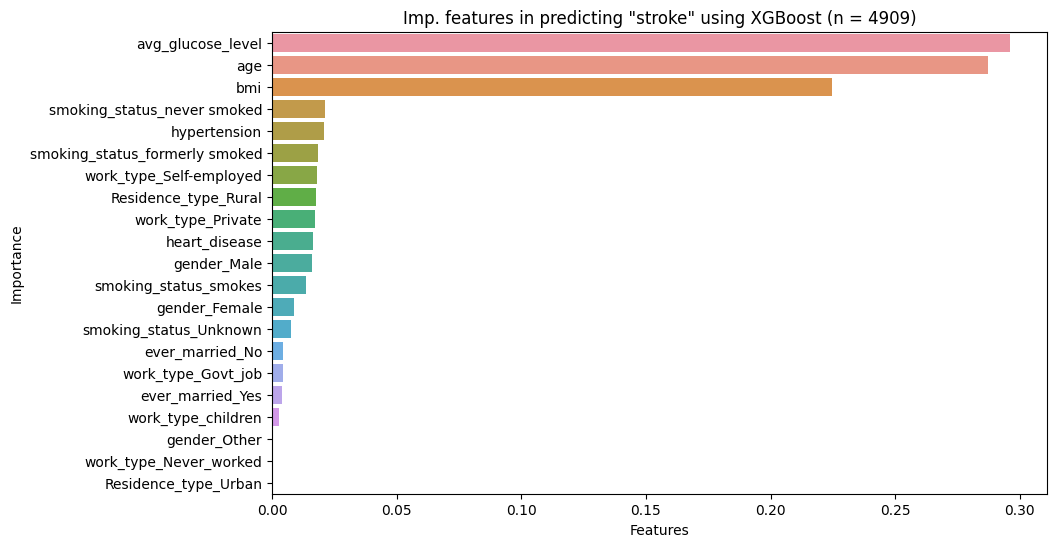

In [ ]:
xgboost.fit(df_X_train, df_Y_train)
feat_dict= {}
for col, val in sorted(zip(df_X_train.columns, xgboost.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

plt.figure(figsize=(10, 6))
plot2 = sns.barplot(x=feat_df.Importance, y=feat_df.Feature)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Imp. features in predicting "stroke" using XGBoost (n = 4909)')

plt.show()

**Comments**

All three models have the same top 3 features as the most imp. features.

**XGBoost on top 7 features**

In [ ]:
top_7_features = ['avg_glucose_level', 'age', 'bmi', 'smoking_status_never smoked', 'hypertension', 'smoking_status_formerly smoked', 'work_type_Self-employed']

# Select the specified features in df_X_train and df_X_test
df_X_train_top7 = df_X_train[top_7_features]
df_X_test_top7 = df_X_test[top_7_features]

In [ ]:
xgb_param_grid = { # hyperparameters for  XGBoost
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.08, 0.2,0.3,0.5,0.8,1],
    'max_depth': [1,3,6,9]}


xgboost_top7 = xgb.XGBClassifier(random_state=3427) # initialize model

# Perform grid search 10 fold cross-validation
xgb_grid_search = GridSearchCV(xgboost_top7, xgb_param_grid, cv=10, scoring='f1', n_jobs=-1)
xgb_grid_search.fit(df_X_train_top7, df_Y_train)

best_xgb_model_top7 = xgb_grid_search.best_estimator_

xgb_test_f1_score_top7 = metrics.f1_score(df_Y_test, best_xgb_model_top7.predict(df_X_test_top7))
xgb_test_precision_score_top7 = metrics.precision_score(df_Y_test, best_xgb_model_top7.predict(df_X_test_top7))
xgb_test_recall_score_top7 = metrics.recall_score(df_Y_test, best_xgb_model_top7.predict(df_X_test_top7))

best_learning_rate_xgboost_top7 = xgb_grid_search.best_params_['learning_rate']

print("XGBoost Classifier:")
print("F1 score on test dataset: {:.4f}".format(xgb_test_f1_score_top7))
print("Precision score on test dataset: {:.4f}".format(xgb_test_precision_score_top7))
print("Recall score on test dataset: {:.4f}".format(xgb_test_recall_score_top7))
print("Best learning rate:", best_learning_rate_xgboost)

XGBoost Classifier:
F1 score on test dataset: 0.1408
Precision score on test dataset: 0.2381
Recall score on test dataset: 0.1000
Best learning rate: 1


**Comments**

The original model with all features performed better. Some possible reasons behind this are:
- Top 7 features don't account for all the variation in target variable (i.e., removing other features lead to loss in critical information).
- Overfitting: On the opposite side, selecting top 7 features may have caused overfitting and resulted in a lower performance on test data.
- Feature correlation: If some of the top 7 features are highly correlated, they would not provide addditional unique information to the model.
- Insufficient hyperparameter tuning: We did not tune the hyperparameters specifically for this model; there is scope for further optimization.


**Compare the results on the test dataset from XGBoost, HistGradientBoostingClassifier, GradientBoostingClassifier**

In [ ]:
# Decision Tree
print("Decision Tree:")
print("F1 score on test dataset: {:.4f}".format(decisiontree_f1))
print("Precision score on test dataset: {:.4f}".format(decisiontree_precision))
print("Recall score on test dataset: {:.4f}".format(decisiontree_recall))

# Random Forest
print("\nRandom Forest:")
print("F1 score on test dataset: {:.4f}".format(rf_f1))
print("Precision score on test dataset: {:.4f}".format(rf_precision))
print("Recall score on test dataset: {:.4f}".format(rf_recall))


# Gradient Boosting Classifier
print("\nGradientBoostingClassifier from 3.1:")
print("F1 score on test dataset: {:.4f}".format(gb_test_f1_score))
print("Precision score on test dataset: {:.4f}".format(gb_test_precision))
print("Recall score on test dataset: {:.4f}".format(gb_test_recall))

# Histogram Gradient Boosting Classifier
print("\nHistGradientBoostingClassifier from 3.1:")
print("F1 score on test dataset: {:.4f}".format(hist_gb_test_f1_score))
print("Precision score on test dataset: {:.4f}".format(hist_gb_test_precision_score))
print("Recall score on test dataset: {:.4f}".format(hist_gb_test_recall_score))

#XGBoost
print("\nXGBoost Classifier:")
print("F1 score on test dataset: {:.4f}".format(xgb_test_f1_score))
print("Precision score on test dataset: {:.4f}".format(xgb_test_precision_score))
print("Recall score on test dataset: {:.4f}".format(xgb_test_recall_score))

Decision Tree:
F1 score on test dataset: 0.0870
Precision score on test dataset: 0.0952
Recall score on test dataset: 0.0800

Random Forest:
F1 score on test dataset: 0.0000
Precision score on test dataset: 0.0000
Recall score on test dataset: 0.0000

GradientBoostingClassifier from 3.1:
F1 score on test dataset: 0.1316
Precision score on test dataset: 0.1923
Recall score on test dataset: 0.1000

HistGradientBoostingClassifier from 3.1:
F1 score on test dataset: 0.2727
Precision score on test dataset: 0.3158
Recall score on test dataset: 0.2400

XGBoost Classifier:
F1 score on test dataset: 0.1892
Precision score on test dataset: 0.2917
Recall score on test dataset: 0.1400


In [ ]:
# The best performing model is HistGradientBoostingClassifier, with f-1 score of 0.27 and precision of 0.31. The worst performing model, surprisingly
# is Random Forest (0 F-1, precision and recall); possibly because we did not tune the RF model well (only used two hyperparams) and/or because the imbalance in dataset is affecting each node.
# We might get better results with weighted sub-sampling for each forest.

# From sklearn documentation: "HGBT uses gradient boosting to iteratively improve the model’s performance by fitting each tree to the negative
# gradient of the loss function with respect to the predicted value. RFs, on the other hand, are based on bagging and use a majority vote to predict the outcome". This means that
# a possible reason why HistGradientBoostingClassifier performed better than random forests is that it fits the new tree to the negative gradient (i.e., residuals), essentially penalizing
# misclassification (same as GradientBoostingClassifier).

# I would choose HistGradientBoostingClassifier as it has the highest precision score, recall and F-1 score - all three metrics crucial for our dataset which is highly imbalanced.

## **Calibration**

In [ ]:
# Predict probabilities on test dataset
y_probs = best_xgb_model.predict_proba(df_X_test)[:, 1]

# Calculate Brier Score
brier_score = brier_score_loss(df_Y_test, y_probs)

print("Brier Score for XGBoost model: {:.4f}".format(brier_score))


Brier Score for XGBoost model on the test dataset: 0.0538


In [ ]:
# Calibrate using Platt scaling
platt_calibrated = CalibratedClassifierCV(best_xgb_model, method='sigmoid', cv='prefit')
platt_calibrated.fit(df_X_train, df_Y_train)

# Calibrate using isotonic regression
isotonic_calibrated = CalibratedClassifierCV(best_xgb_model, method='isotonic', cv='prefit')
isotonic_calibrated.fit(df_X_train, df_Y_train)

# Predict probabilities on test data
y_probs_platt = platt_calibrated.predict_proba(df_X_test)[:, 1]
y_probs_isotonic = isotonic_calibrated.predict_proba(df_X_test)[:, 1]

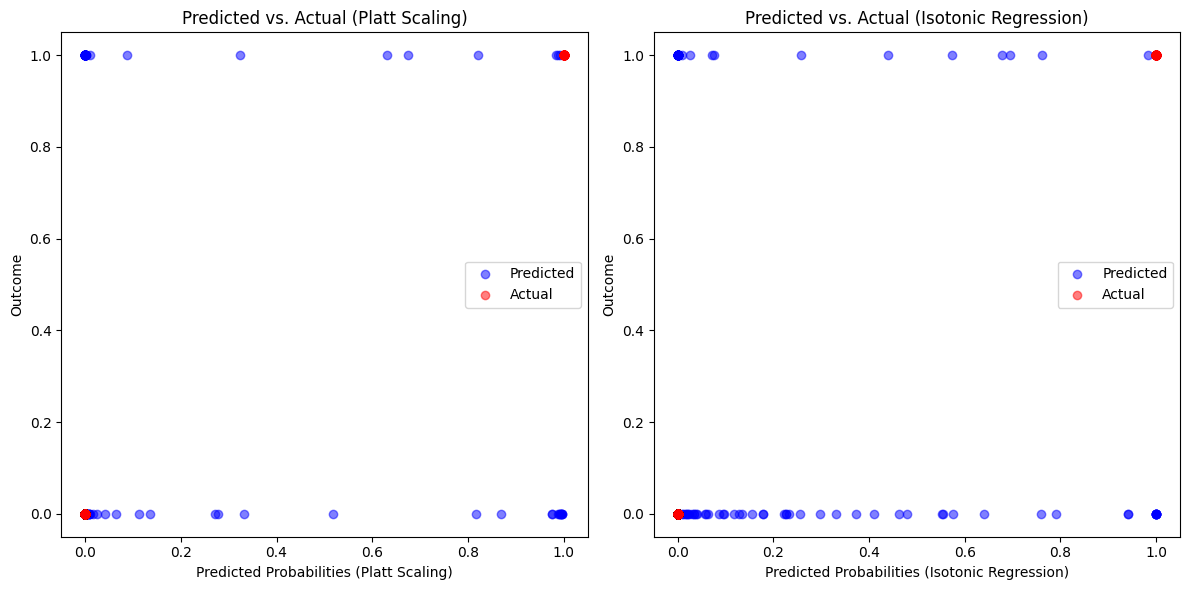

In [ ]:
# Plot of predicted vs actual on test dataset from both caliberation methods
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for Platt Scaling
ax1 = axs[0]
ax1.scatter(y_probs_platt, df_Y_test, alpha=0.5, c='blue', label='Predicted')
ax1.scatter(df_Y_test, df_Y_test, alpha=0.5, c='red', label='Actual')
ax1.set_xlabel('Predicted Probabilities (Platt Scaling)')
ax1.set_ylabel('Outcome')
ax1.set_title('Predicted vs. Actual (Platt Scaling)')
ax1.legend()

# Scatter plot for Isotonic Regression
ax2 = axs[1]
ax2.scatter(y_probs_isotonic, df_Y_test, alpha=0.5, c='blue', label='Predicted')
ax2.scatter(df_Y_test, df_Y_test, alpha=0.5, c='red', label='Actual')
ax2.set_xlabel('Predicted Probabilities (Isotonic Regression)')
ax2.set_ylabel('Outcome')
ax2.set_title('Predicted vs. Actual (Isotonic Regression)')
ax2.legend()

plt.tight_layout()
plt.show()


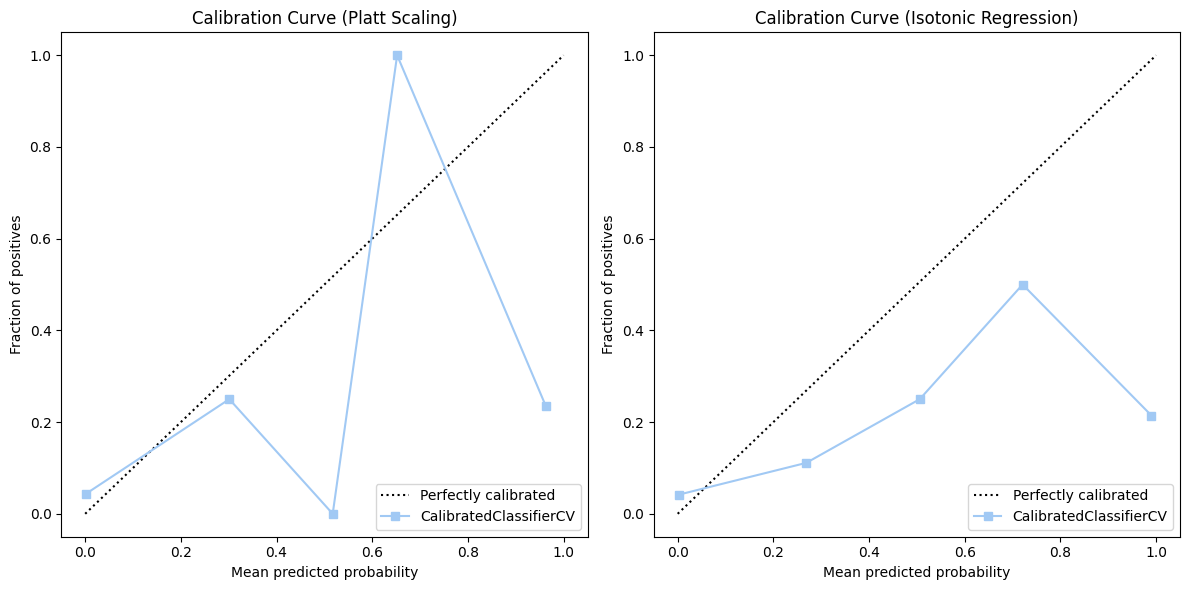

In [ ]:
# Caliberation curve plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Platt scaling
ax1 = axs[0]
disp_platt = CalibrationDisplay.from_estimator(platt_calibrated, df_X_test, df_Y_test, ax=ax1)
disp_platt.ax_.set_xlabel('Mean predicted probability')
disp_platt.ax_.set_ylabel('Fraction of positives')
disp_platt.ax_.set_title('Calibration Curve (Platt Scaling)')

# Isotonic regression
ax2 = axs[1]
disp_iso = CalibrationDisplay.from_estimator(isotonic_calibrated, df_X_test, df_Y_test, ax=ax2)
disp_iso.ax_.set_xlabel('Mean predicted probability')
disp_iso.ax_.set_ylabel('Fraction of positives')
disp_iso.ax_.set_title('Calibration Curve (Isotonic Regression)')

plt.tight_layout()
plt.show()

**Report brier scores from both the calibration methods.**

In [ ]:
# Brier Score after calibration for each method
brier_score_platt = brier_score_loss(df_Y_test, y_probs_platt)
brier_score_isotonic = brier_score_loss(df_Y_test, y_probs_isotonic)

print("\nBefore caliberation")
print("Brier Score for XGBoost model: {:.4f}".format(brier_score))
print("\nAfter caliberation")
print("Brier Score after Platt Scaling: {:.4f}".format(brier_score_platt))
print("Brier Score after Isotonic Regression: {:.4f}".format(brier_score_isotonic))


# Comment: Caliberation methods do seem to provide slightly better-calibrated predicted probabilities.


Before caliberation
Brier Score for XGBoost model: 0.0538

After caliberation
Brier Score after Platt Scaling: 0.0551
Brier Score after Isotonic Regression: 0.0555
